In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

import string
import unicodedata
from pathlib import Path
import collections
import itertools
import math

from IPython.display import clear_output
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Loading Data

In [3]:
# name data from: https://download.pytorch.org/tutorial/data.zip

In [4]:
if not Path("names").is_dir():
  !curl "https://download.pytorch.org/tutorial/data.zip" -o "data.zip"
  !unzip -j "data.zip" "data/names/*" -d "names"

In [5]:
all_chars = string.ascii_letters + " .,;'-"
print(all_chars)

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'-


In [6]:
def sanitise_line(line):
    # https://stackoverflow.com/a/518232/5013267
    return ''.join(
        c for c in unicodedata.normalize('NFD', line)
        if unicodedata.category(c) != 'Mn'
        and c in all_chars
    )

In [7]:
name_data = {}
for path in Path("names").rglob("*.txt"):
    with open(path, "r", encoding="utf8") as f:
        names = []
        for line in f.read().strip().split("\n"):
            names.append(sanitise_line(line))
        name_data[path.stem] = names
    
    print(f"Loaded: {path}")

Loaded: names/Arabic.txt
Loaded: names/Chinese.txt
Loaded: names/Czech.txt
Loaded: names/Dutch.txt
Loaded: names/English.txt
Loaded: names/French.txt
Loaded: names/German.txt
Loaded: names/Greek.txt
Loaded: names/Irish.txt
Loaded: names/Italian.txt
Loaded: names/Japanese.txt
Loaded: names/Korean.txt
Loaded: names/Polish.txt
Loaded: names/Portuguese.txt
Loaded: names/Russian.txt
Loaded: names/Scottish.txt
Loaded: names/Spanish.txt
Loaded: names/Vietnamese.txt


# Data Preparation Stuff

In [8]:
class OneHotTranslator:
    def __init__(self, elements):
        self.elements = elements
        self.n_elements = len(self.elements)
        
    def index_to_vec(self, index):
        return F.one_hot(torch.tensor([index]), num_classes=self.n_elements)[0]
    
    def index_from_vec(self, vec):
        return vec.argmax()
    
    def elm_to_vec(self, elm):
        return self.index_to_vec(self.elements.index(elm))
    
    def elm_from_vec(self, vec):
        return self.elements[int(self.index_from_vec(vec))]
    
    def __len__(self):
        return self.n_elements
    
    def __getitem__(self, val):
        if isinstance(val, int):
            return self.index_to_vec(val)
        else:
            return self.elm_to_vec(val)

In [9]:
category_translator = OneHotTranslator(tuple(name_data.keys()))
print(category_translator.elements)
print("len:", len(category_translator))

('Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese')
len: 18


In [10]:
char_translator = OneHotTranslator(["<SOS>", "<EOS>"] + list(all_chars))
print(char_translator.elements)
print("len:", len(char_translator))

['<SOS>', '<EOS>', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', ' ', '.', ',', ';', "'", '-']
len: 60


In [11]:
# convenience functions
def build_name(name, fixed_length):
    """
    Build a list of one-hot encoded vectors representing the given name string
    """
    ret = [char_translator.elm_to_vec(char) for char in (["<SOS>"] + list(name) + ["<EOS>"])]
    
    while len(ret) < fixed_length:
        ret.append(char_translator.elm_to_vec("<EOS>"))
    
    return ret

def unbuild_name(t_chars):
    """
    Inverse of build_name
    """
    return "".join([char_translator.elm_from_vec(vec) for vec in t_chars])

def build_category(category):
    """
    Build a one-hot encoded vector representing the given category string
    """
    return category_translator.elm_to_vec(category)

def unbuild_category(vec):
    """
    Inverse of build_category
    """
    return category_translator.elm_from_vec(vec)

In [12]:
# torch.stack(build_name("hi", 10)).shape

In [13]:
# simple Dataset class wrapper around the above variables
class NamesDataset(Dataset):
    def __init__(self, max_length):
        self.max_length = max_length
        self._data_pairs = [(cat, name) for cat in name_data for name in name_data[cat]]
    
    def __len__(self):
        return len(self._data_pairs)
    
    def __getitem__(self, index):
        cat, name = self._data_pairs[index]
        return build_category(cat), build_name(name, self.max_length)

# Neural

In [14]:
class SeqModel(nn.Module):
    def __init__(self, prime_size, input_size):
        super().__init__()
        self.prime_size = prime_size
        self.input_size = input_size
        self.hidden_size = 128
        
        self.lstm = nn.LSTMCell(self.input_size + self.prime_size, self.hidden_size)
        
        # NB: output size = input size
        self.fc = nn.Linear(self.hidden_size, 60)
        self.fc2 = nn.Linear(60, self.input_size)
        
        self.dropout = nn.Dropout(0.1)
        self.dropout2 = nn.Dropout(0.1)
        self.lsoftmax = nn.LogSoftmax(dim=1)
        
    def forward(self, t_prime, t_input, t_hidden, t_cell):
        # t_prime:     batches of vectors for the LSTM to be primed on
        #              shape: (N, prime_size)
        #
        # t_input:     shape: (N, input_size)
        #              t_input[0]: one-hot vector encoding of a character
        #
        # t_hidden:    shape: (N, hidden_size)
        #
        # t_cell:      shape: (N, hidden_size)
        
        # lstm_input:  t_prime and t_input concated together
        #              shape: (N, prime_size + input_size)
        lstm_input = torch.cat((t_prime, t_input), dim=1)
        t_hidden, t_cell = self.lstm(lstm_input.float(), (t_hidden, t_cell))
        
        # t_output:    shape: (N, input_size)
        #              NB: t_output's shape = t_input's shape
        t_output = self.fc(self.dropout(t_hidden))
        t_output = self.fc2(self.dropout2(F.relu(t_output)))
        t_output = self.lsoftmax(t_output)
        
        return t_output, t_hidden, t_cell
    
    def init_hidden(self, batch_size=1):
        t_hidden = torch.zeros(batch_size, self.hidden_size)
        t_cell = torch.zeros(batch_size, self.hidden_size)
        
        return t_hidden, t_cell

In [15]:
model = SeqModel(len(category_translator), len(char_translator))
model.to(device)

SeqModel(
  (lstm): LSTMCell(78, 128)
  (fc): Linear(in_features=128, out_features=60, bias=True)
  (fc2): Linear(in_features=60, out_features=60, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
  (lsoftmax): LogSoftmax(dim=1)
)

In [16]:
# test_category_index = 0

# t_prime = category_translator[test_category_index].view(1, len(category_translator))
# print("t_prime shape:\t", t_prime.shape)

# t_input = char_translator["<SOS>"].view(1, len(char_translator))
# print("t_input shape:\t", t_input.shape)

# t_hidden, t_cell = model.init_hidden(1)
# print("t_hidden shape:\t", t_hidden.shape)
# print("t_cell shape:\t", t_cell.shape)

In [17]:
# t_output, t_hidden, t_cell = model.forward(t_prime, t_input, t_hidden, t_cell)
# print("t_output shape:\t", t_output.shape)
# print("t_hidden shape:\t", t_hidden.shape)
# print("t_cell shape:\t", t_cell.shape)

# Eval

In [18]:
def generate(max_length, category_name="German", N=3, ignore=True):
    with torch.no_grad():
        t_prime = category_translator[category_name].unsqueeze(0).repeat((N, 1)).to(device)
        t_char = char_translator["<SOS>"].unsqueeze(0).repeat((N, 1)).to(device)
        t_hidden, t_cell = map(lambda x: x.to(device), model.init_hidden(N))

        output_dict = collections.defaultdict(str)
        done_set = []
        for char_index in range(max_length):
            t_output, t_hidden, t_cell = model(t_prime, t_char, t_hidden, t_cell)
            
            for n in range(N):
                if ignore and n in done_set:
                    continue
                    
                translated_char = char_translator.elm_from_vec(t_output[n])
                if ignore and translated_char == "<EOS>":
                    done_set.append(n)
                    continue
                    
                output_dict[n] += translated_char
        
        return [output_dict[n] for n in range(N)]

# Training

In [19]:
max_length = max([len(name) for name in itertools.chain(*name_data.values())]) + 2  # +2 for SOS and EOS
print(max_length)

22


In [20]:
sample_count = len(tuple(itertools.chain(*name_data.values())))
print(sample_count)

20074


In [21]:
# config
batch_size = 64
num_epochs = 100
num_batches = math.ceil(sample_count/batch_size) * num_epochs
learning_rate = 0.0003
plot_limit = None

In [22]:
num_batches

31400

In [23]:
train_dataloader = DataLoader(NamesDataset(max_length), batch_size=batch_size, shuffle=True, collate_fn=lambda x: x)

In [24]:
losses = collections.deque(maxlen=plot_limit)

In [25]:
criterion = nn.NLLLoss()
optimiser = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.01)
# optimiser = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

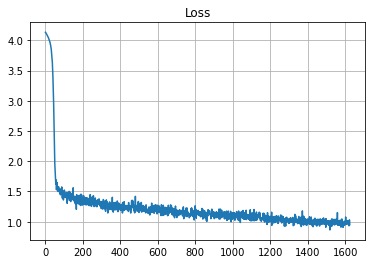

epoch: 5 batch_no: 54 loss: 0.952056
Aaaaaaaa
Aaaaaaaaaaa
Aaaaaaaaa


In [ ]:
for epoch_no in range(num_epochs):
    for batch_no, batch in enumerate(train_dataloader):
        t_prime = torch.stack([sample[0] for sample in batch]).to(device)
        t_hidden, t_cell = map(lambda x: x.to(device), model.init_hidden(t_prime.size(0)))

        model.zero_grad()
        loss = 0
        for char_index in range(max_length - 1):
            t_char = torch.stack([sample[1][char_index] for sample in batch]).to(device)
            t_output, t_hidden, t_cell = model(t_prime, t_char, t_hidden, t_cell)

            t_target = torch.stack([sample[1][char_index + 1].argmax() for sample in batch]).to(device)
            loss += criterion(t_output, t_target)

        loss.backward()
        optimiser.step()

        name_loss = loss.item() / (max_length - 1)
        losses.append(name_loss)

        plt.figure()
        plt.plot(losses, scalex=True)
        plt.title("Loss")
        plt.grid(True)
        plt.show()

    #     gen_categories = ['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']
    #     gen_string = ""
    #     for gen_category in gen_categories:
    #         gen_string += gen_category + ":\n"
    #         gen_string += "\n".join(generate(max_length, category_name=gen_category))
    #         gen_string += "\n"
        gen_string = "\n".join(generate(max_length))

        print("epoch: {} batch_no: {} loss: {:.06f}\n{}".format(
            epoch_no, 
            batch_no, 
            name_loss,
            gen_string
        ))
        clear_output(wait=True)
        

# Post-Training Eval

In [ ]:
generate(max_length)